In [45]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
# from matplotlib import pyplot as plt
import scipy
from scipy.optimize import fsolve
from functools import partial

In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [47]:
class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска.
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)

In [93]:
def plot_convergence_2d(func, steps, ax, xlim, ylim, cmap="viridis", title=""):
    """
    Функция отрисовки шагов градиентного спуска.
    Не меняйте её код без необходимости!
    :param func: функция, которая минимизируется градиентным спуском
    :param steps: np.array[N x 2] — шаги алгоритма
    :param ax: холст для отрисовки графика
    :param xlim: tuple(float), 2 — диапазон по первой оси
    :param ylim: tuple(float), 2 — диапазон по второй оси
    :param cmap: str — название палитры
    :param title: str — заголовок графика
    """

    ax.set_title(title, fontsize=20, fontweight="bold")
    # Отрисовка значений функции на фоне
    xrange = np.linspace(*xlim, 100)
    yrange = np.linspace(*ylim, 100)
    grid = np.meshgrid(xrange, yrange)
    X, Y = grid
    fvalues = func(
        np.dstack(grid).reshape(-1, 2)
    ).reshape((xrange.size, yrange.size))
    ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)
    CS = ax.contour(xrange, yrange, fvalues)
    ax.clabel(CS, CS.levels, inline=True)
    # Отрисовка шагов алгоритма в виде стрелочек
    arrow_kwargs = dict(linestyle="--", color="black", alpha=0.8)
    for i, _ in enumerate(steps):
        if i + 1 < len(steps):
            ax.arrow(
                *steps[i],
                *(steps[i+1] - steps[i]),
                **arrow_kwargs
            )
    # Отрисовка шагов алгоритма в виде точек
    n = len(steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(steps[:, 0], steps[:, 1], c=color_list, zorder=10)
    ax.scatter(steps[-1, 0], steps[-1, 1], color="red")
                #color="red", label=f"estimate = {np.round(steps[-1], 2)}")
    # Финальное оформление графиков
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.legend(fontsize=16)

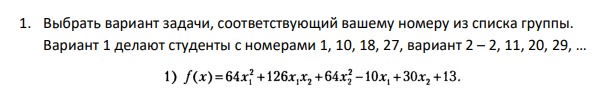

In [49]:
def f(x):
    return 64 * x[0]**2 + 126 * x[0] * x[1] + 64 * x[1]**2 - 10 * x[0] + 30 * x[1] + 13

In [50]:
def grad_f(x):
    dfdx1 = 128 * x[0] + 126 * x[1] - 10
    dfdx2 = 128 * x[1] + 126 * x[0] + 30
    return np.array([dfdx1, dfdx2])

In [76]:
def hesse_f(x, inv=False):
    hessian = np.array([[128, 126],
                        [126, 128]])
    if not inv:
        return hessian
    else:
        return np.linalg.inv(hessian)

In [51]:
x0 = np.array([0, 0])
tol = 1e-5

In [52]:
res = minimize(f, x0, method='Nelder-Mead',
               options={'xatol': 1e-8, 'disp': True})
print(f'min x: {res.x}, f(x) = {f(res.x)}')

Optimization terminated successfully.
         Current function value: -187.393701
         Iterations: 99
         Function evaluations: 201
min x: [  9.96063035 -10.03937062], f(x) = -187.39370078740131


In [73]:
# x = np.outer(np.linspace(-11, 11, 1000), np.ones(1000))
# y = x.copy().T
# z = f((x, y))

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(res.x[0], res.x[1], f(res.x), c='black', s=50);
# ax.plot_surface(x, y, z);

# plt.show()

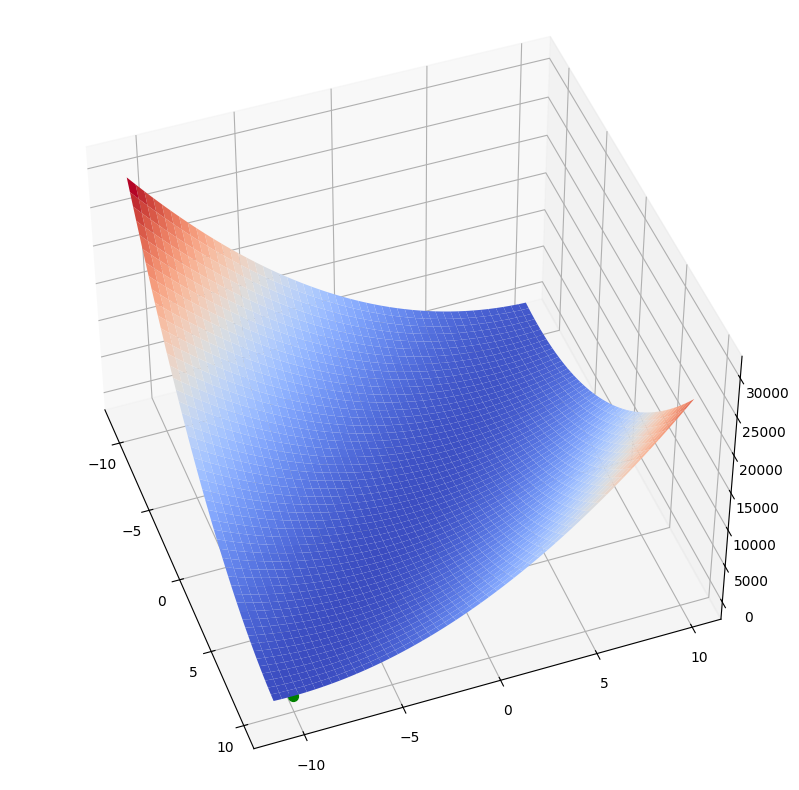

In [74]:
# Настраиваем 3D график
fig = plt.figure(figsize=[15, 10])
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection = '3d')

# Задаем угол обзора
ax.view_init(45, -20)

# Создаем данные для графика
X = np.arange(-11, 10, 0.01)
Y = np.arange(-11, 10, 0.01)
X, Y = np.meshgrid(X, Y)
Z = f(np.array([X,Y]))

# Рисуем поверхность
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.scatter(res.x[0], res.x[1], f(res.x), c='green', s=50);


In [36]:
def fibonacci_numbers(max_value):

    num1, num2 = 1, 1
    
    yield num1
    
    if num1 > max_value and  num2 > max_value:
        return

    if num1 < max_value and num2 > max_value:
        yield num2

    while num2 < max_value:
        num1, num2 = num2, num1 + num2
        yield num2

In [37]:
def fibonacci_method(func, a, b, interval_length, eps, callback=None):
    
    if callback is None:
        callback = lambda c, v: 0
        
    max_value = (b - a) / interval_length
    fib_nums = [num for num in fibonacci_numbers(max_value)]
    length = len(fib_nums) - 1
    y = a + fib_nums[length - 2] / fib_nums[length] * (b - a)
    z = a + fib_nums[length - 1] / fib_nums[length] * (b - a)
    k = 1
    max_k = length - 3
    
    func_y, func_z = func(y), func(z)
    
    for k in range(max_k + 1):        
        if func_y <= func_z:
            less = True
            b, z = z, y
            y = a + fib_nums[length - k - 3] / fib_nums[length - k - 1] * (b - a)
            callback(b, func_z)
        else:
            less = False
            a, y = y, z
            z = a + fib_nums[length - k - 2] / fib_nums[length - k - 1] * (b - a)
            callback(a, func_y)
        func_y, func_z = (func(y), func_y) if less else (func_z, func(z))
        
    y = z
    z = y + eps
    x = (a + z) / 2 if func_y <= func(z) else (y + b) / 2
    callback(x, func(x))
    return x, max_k + 1

In [38]:
def steepest_descent_method(func, gfunc, x, eps,
                          lr_min=1e-7, lr_max=2,
                          n_eps=0.1, max_iter=100_000,
                          callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    def fi(t, x, d):
        nonlocal func
        return func(x + t * d)
    
    fib_k = 0
    
    for k in range(max_iter):
        callback(x, func(x))
        grad = gfunc(x)
        d = - grad
        fi_x_d = partial(fi, x=x, d=d)
        t, fc = fibonacci_method(fi_x_d, lr_min, lr_max, n_eps, n_eps/2)
        fib_k += fc
        t = 0.001
        x_prev = x
        x = x + t * d
        
        if np.linalg.norm(grad) < eps:
            callback(x, func(x))
            print(fib_k)
            return x, k + 1

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    print(fib_k)
    return x, max_iter

In [77]:
def marquardt_method(func, gfunc, hfunc, x, eps, mu=1e4,
                     max_iter=100_000, callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    func_x_prev = func(x)
        
    for k in range(max_iter):
        
        callback(x, func(x))
        grad = gfunc(x)
        
        if np.linalg.norm(grad) < eps:
            callback(x, func(x))
            return x, k + 1
        
        hesse = hfunc(x)
        d = - np.linalg.inv(hesse + mu * np.eye(2)) @ grad
        x = x + d
        func_x = func(x)
        mu = mu / 2 if func_x < func_x_prev else mu * 2
        func_x_prev = func_x

    if print_info:
        print('Max iterations. Stop')
    callback(x, func(x))
    return x, max_iter

In [86]:
def get_simplex(x, length, n=2):
    simplex = np.array([x, np.zeros(2), np.zeros(2)])
    
    for i in range(1, len(simplex)):
        for j in range(n):
            if i == j + 1:
                simplex[i][j] = (simplex[0][j]
                                + (np.sqrt(n + 1) - 1) / (n * np.sqrt(2)) * length)
            else:
                simplex[i][j] = (simplex[0][j]
                                 + (np.sqrt(n + 1) + n - 1) / (n * np.sqrt(2)) * length)
    return simplex

In [87]:
def simplex_reduction(simplex, delta):
    for i in range(1, len(simplex)):
        simplex[i] = simplex[0] + delta * (simplex[i] - simplex[0])
    return simplex

In [97]:
def regular_simplex_method(func, x, length, eps, delta=0.85,
                           n=2, max_iter=100_000, callback=None,
                          print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    idx_max_f = None
    vect_func = np.vectorize(f, signature="(n)->()")
    simplex = get_simplex(x, length, n)
    func_x = vect_func(simplex)
    callback(x, func(x))
    
    for k in range(max_iter):
        
        if idx_max_f is None:
            idx_max_f = np.argmax(func_x)
            another_idx = [i for i in range(n + 1) if i != idx_max_f]

        cm = np.sum(np.array([simplex[i] for i in range(n + 1) if i != idx_max_f]), axis=0)
        new_vertex = (2 / n * cm - simplex[idx_max_f])
        func_x_new = func(new_vertex)
        
        if func_x_new < func_x[idx_max_f]:
            callback(new_vertex, func(new_vertex))
            func_x_prev = func_x
            func_x[idx_max_f] = func_x_new
            simplex[idx_max_f] = new_vertex
            idx_max_f = None

        else:
            if len(another_idx) == 0:
                simplex = simplex_reduction(simplex, delta)
                length = length * delta
                if length * 2 < eps:
                    return np.mean(simplex, axis=0), k + 1
                idx_max_f = None
            else:
                idx_max_f = another_idx[0]
                another_idx = [idx for idx in another_idx if idx != another_idx[0]]
            
        
    if print_info:
        print('Max iterations. Stop')
    callback(np.mean(simplex, axis=0), func(x))
    return np.mean(simplex, axis=0), max_iter

In [98]:
def best_test_method(func, x, min_lr, betta=0.3, m=20,
                     lr=1, max_iter=100_000,
                     callback=None, print_info=False):
    
    if callback is None:
        callback = lambda c, v: 0
    
    vect_func = np.vectorize(func, signature="(n)->()")
    
    for k in range(max_iter):
        np.random.seed(k)
        vectors = np.random.uniform(-1, 1, size=(m, 2))
        vectors = vectors / np.linalg.norm(vectors, axis=1)[..., None]
        y = x + lr * vectors
        func_y = vect_func(y)
        idx_min_func = np.argmin(func_y)
        if func_y[idx_min_func] < func(x):
            x = y[idx_min_func]
            callback(x, func(x))
        else:
            lr = lr * betta
            if lr < min_lr:
                return x, k + 1
            
    return x, max_iter

29688


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'best_test_method')

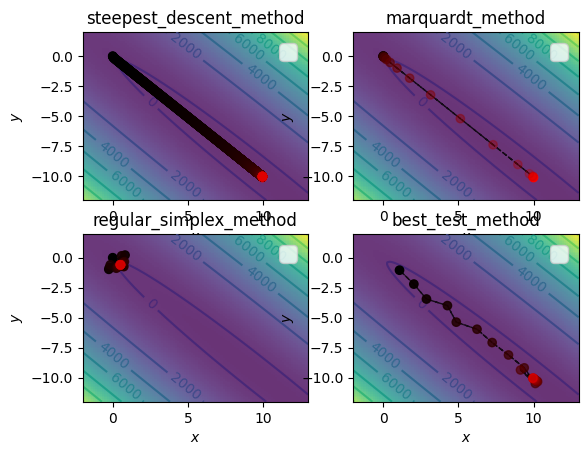

In [99]:
fig, ax = plt.subplots(2, 2)

callback = LoggingCallback()
sdx, sdk = steepest_descent_method(f, grad_f, x0, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[0, 0],
                    xlim=(-2, 13),
                    ylim=(-12, 2),
                   )
ax[0, 0].set_title('steepest_descent_method')

callback = LoggingCallback()
mx, mk = marquardt_method(f, grad_f, hesse_f, x0, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[0, 1],
                    xlim=(-2, 13),
                    ylim=(-12, 2),
                   )
ax[0, 1].set_title('marquardt_method')


callback = LoggingCallback()
rsx, rsk = regular_simplex_method(f, x0, 1, tol, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[1, 0],
                    xlim=(-2, 13),
                    ylim=(-12, 2),
                   )
ax[1, 0].set_title('regular_simplex_method')

callback = LoggingCallback()
btx, btk = best_test_method(f, x0, tol, lr=5, callback=callback)
plot_convergence_2d(np.vectorize(f, signature="(n)->()"),
                    np.vstack(callback.x_steps),
                    ax=ax[1, 1],
                    xlim=(-2, 13),
                    ylim=(-12, 2),
                   )
ax[1, 1].set_title('best_test_method')

In [105]:
results = {
    'method': ['steepest_descent_method', 'marquardt_method', 'regular_simplex_method', 'best_test_method'],
    'iterations': [sdk, mk, rsk, btk],
    'func_evals': [sdk + 18031, mk + 1, rsk, 21*btk],
    'grad_evals': [sdk, mk, 0, 0],
    'hesse_eval': [0, mk, 0, 0],
    '[x1, x2]': [np.round(sdx, 5), np.round(mx, 5), np.round(rsx, 5), np.round(btx, 5)],
    'f(x)': [np.round(f(sdx), 5), np.round(f(mx), 5), np.round(f(rsx), 5), np.round(f(btx), 5)],
    '||x - x*|| < eps': [np.linalg.norm(sdx - res.x) < tol, np.linalg.norm(mx - res.x) < tol,
                        np.linalg.norm(rsx - res.x) < tol, np.linalg.norm(btx - res.x)  < tol]
    
}
pd.DataFrame(results)

,method,iterations,func_evals,grad_evals,hesse_eval,"[x1, x2]",f(x),||x - x*|| < eps
0,steepest_descent_method,7422,25453,7422,0,"[9.96063, -10.03937]",-187.39370,True
1,marquardt_method,20,21,20,20,"[9.96063, -10.03937]",-187.39370,True
2,regular_simplex_method,282,282,0,0,"[0.5143, -0.59304]",-8.92745,False
3,best_test_method,42,882,0,0,"[9.96062, -10.03936]",-187.39370,False
